### Setting up sklearn Multilayer Perceptron

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os, sys, subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tqdm import tqdm
import itertools 
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

MPLRegressor setup and loading data 

In [2]:
# ROOT_DIR - root directory
ROOT_DIR = os.getcwd()+'/'

# FEATURE_DIR - directory where feature dataframes are saved
DATA_DIR = ROOT_DIR + 'dataframes/'

FIGURE_DIR = ROOT_DIR + 'figures/'

### Data Processing: mRNA features first

In [3]:
DF_mRNA_features = pd.read_csv(DATA_DIR+'mRNA_features.csv',index_col=0)
DF_physical_features = pd.read_csv(DATA_DIR+'physical_features.csv',index_col=0)
DF_prest = pd.concat([pd.read_csv(DATA_DIR+'DF_prest_features_1.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_2.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_3.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_4.csv',index_col=0)])

Check mRNA feature dataset and remove RNA folding energy and tRNA adaptation index

Now that the 3D features of the mRNA sequences have been dropped, next check Amino Acid sequences physical properties

In [4]:
# all 20 Amino Acids represented as FASTA letters 
amino_acids = 'ARNDCQEGHILKMFPSTWYV'

In [5]:
aa_features = ['list_comp_A','list_comp_R','list_comp_N',
               'list_comp_D','list_comp_C','list_comp_Q','list_comp_E','list_comp_G',
               'list_comp_H','list_comp_I','list_comp_L','list_comp_K','list_comp_M',
               'list_comp_F','list_comp_P','list_comp_S','list_comp_T','list_comp_W',
               'list_comp_Y','list_comp_V',
               # Amino acid types
               'frac_aliphatic', 'frac_uncharged_polar', 'frac_polar',
               'frac_hydrophobic', 'frac_positive', 'frac_sulfur', 'frac_negative', 'frac_amide',
               'frac_alcohol']


phys_features = ['aa_len',                                        
                # Physical properties
                 'bio_pI','bio_mW','bio_aromaticity','bio_instability','bio_gravy','abs_avg_charge','abs_charge',
                 'avg_charge']

rna_features = ['AAA','AAC','AAT','AAG','ACA','ACC','ACT','ACG','ATA','ATC','ATT','ATG','AGA','AGC','AGT',
                'AGG','CAA','CAC','CAT','CAG','CCA','CCC','CCT','CCG','CTA','CTC','CTT','CTG','CGA','CGC',
                'CGT','CGG','TAA','TAC','TAT','TAG','TCA','TCC','TCT','TCG','TTA','TTC','TTT','TTG','TGA',
                'TGC','TGT','TGG','GAA','GAC','GAT','GAG','GCA','GCC','GCT','GCG','GTA','GTC','GTT','GTG',
                'GGA','GGC','GGT','GGG',
                'GC_content','list_nuc_A','list_nuc_C','list_nuc_G','list_nuc_T',
                'GC30',
                # SD sequences
                'sd_like_fwd','sd_like_fwd_frac','sd_like_rev','sd_like_rev_frac','sd_seq_fwd',
                'sd_seq_fwd_frac','sd_seq_rev','sd_seq_rev_frac']
                # RNA folding, excluded, want to base features on physical properties 
                #['RNA_folding_energy','RNA_40_energy','tAI']
        
ss_features = ['acc20_mean','ss_helix', 'ss_ext', 'ss_c', 'ss8_helix', 'ss8_ext', 'ss8_turn', 'ss8_helix3',
               'ss8_pi_helix', 'ss8_bridge', 'ss8_bend', 'ss8_coil', 'acc_frac',
               'in_gravy','out_gravy', 'acc_hydrophilic_in','acc_hydrophilic_out',
               'acc_hydrophobic_in','acc_hydrophobic_out']
list_of_features = aa_features+phys_features+rna_features+ss_features


In [6]:
DF_prest_MLP = DF_prest[list_of_features]
DF_prest_MLP.shape

(45206, 135)

In [7]:
DF_prest_MLP.head()

,list_comp_A,list_comp_R,list_comp_N,list_comp_D,list_comp_C,list_comp_Q,list_comp_E,list_comp_G,list_comp_H,list_comp_I,...,ss8_bridge,ss8_bend,ss8_coil,acc_frac,in_gravy,out_gravy,acc_hydrophilic_in,acc_hydrophilic_out,acc_hydrophobic_in,acc_hydrophobic_out
0,0.057554,0.057554,0.064748,0.057554,0.050360,0.035971,0.071942,0.043165,0.007194,0.021583,...,0.000000,0.014388,0.546763,0.625899,0.599281,-1.199281,0.057554,0.438849,0.294964,0.115108
1,0.111111,0.069444,0.027778,0.000000,0.027778,0.020833,0.118056,0.076389,0.013889,0.020833,...,0.000000,0.013889,0.423611,0.638889,0.378472,-0.747917,0.069444,0.291667,0.263889,0.215278
2,0.066176,0.139706,0.110294,0.044118,0.058824,0.044118,0.000000,0.022059,0.044118,0.051471,...,0.022059,0.117647,0.235294,0.588235,0.360294,-0.994853,0.066176,0.323529,0.323529,0.176471
3,0.089431,0.056911,0.097561,0.073171,0.024390,0.056911,0.065041,0.048780,0.008130,0.008130,...,0.000000,0.008130,0.430894,0.674797,0.312195,-1.328455,0.073171,0.439024,0.235772,0.162602
4,0.072581,0.072581,0.016129,0.000000,0.072581,0.080645,0.080645,0.064516,0.056452,0.024194,...,0.000000,0.008065,0.395161,0.685484,0.572581,-1.391129,0.048387,0.379032,0.258065,0.193548


Select the top ten predictors from the paper 

In [8]:
# Isoelectric point, the leucine content and various hydrophobicity indicators tend to correlate with protein expression
top_16 = ['bio_pI','list_comp_L','avg_charge','frac_polar',
           'bio_gravy','list_comp_F','ss8_ext','acc_hydrophobic_out',
           'acc_hydrophobic_in','frac_hydrophobic','frac_positive',
           'frac_negative','list_comp_W','list_comp_Y','bio_aromaticity']
# Combine predictors and concentrations to further subsmaple data 
DF_top_16 = pd.concat([DF_prest['conc_cf'],DF_prest_MLP[top_16]],axis=1)
DF_top_16.head()

,conc_cf,bio_pI,list_comp_L,avg_charge,frac_polar,bio_gravy,list_comp_F,ss8_ext,acc_hydrophobic_out,acc_hydrophobic_in,frac_hydrophobic,frac_positive,frac_negative,list_comp_W,list_comp_Y,bio_aromaticity
0,4.3075,5.446350,0.050360,-0.014388,0.410072,-0.600000,0.064748,0.115108,0.115108,0.294964,0.345324,0.122302,0.129496,0.007194,0.021583,0.093525
1,2.9154,6.678894,0.111111,0.000000,0.291667,-0.369444,0.020833,0.013889,0.215278,0.263889,0.472222,0.131944,0.118056,0.020833,0.041667,0.083333
2,1.4877,10.720642,0.058824,0.102941,0.411765,-0.634559,0.044118,0.308824,0.176471,0.323529,0.397059,0.191176,0.044118,0.014706,0.029412,0.088235
3,6.7224,8.979797,0.073171,0.032520,0.341463,-1.016260,0.016260,0.341463,0.162602,0.235772,0.349593,0.178862,0.138211,0.008130,0.032520,0.056911
4,3.3848,9.234802,0.056452,0.064516,0.451613,-0.818548,0.032258,0.080645,0.193548,0.258065,0.322581,0.201613,0.080645,0.000000,0.000000,0.032258


In [9]:
#Randomly sample 10% of the full dataset
DF_one_perc = DF_top_16.sample(frac=0.1)
DF_one_perc.shape

(4521, 16)

In [10]:
#Set X(features) and Y(actual predictors) of entire dataset 
X = DF_prest_MLP[top_16]
Y = DF_prest['conc_cf']
X.head()

,bio_pI,list_comp_L,avg_charge,frac_polar,bio_gravy,list_comp_F,ss8_ext,acc_hydrophobic_out,acc_hydrophobic_in,frac_hydrophobic,frac_positive,frac_negative,list_comp_W,list_comp_Y,bio_aromaticity
0,5.446350,0.050360,-0.014388,0.410072,-0.600000,0.064748,0.115108,0.115108,0.294964,0.345324,0.122302,0.129496,0.007194,0.021583,0.093525
1,6.678894,0.111111,0.000000,0.291667,-0.369444,0.020833,0.013889,0.215278,0.263889,0.472222,0.131944,0.118056,0.020833,0.041667,0.083333
2,10.720642,0.058824,0.102941,0.411765,-0.634559,0.044118,0.308824,0.176471,0.323529,0.397059,0.191176,0.044118,0.014706,0.029412,0.088235
3,8.979797,0.073171,0.032520,0.341463,-1.016260,0.016260,0.341463,0.162602,0.235772,0.349593,0.178862,0.138211,0.008130,0.032520,0.056911
4,9.234802,0.056452,0.064516,0.451613,-0.818548,0.032258,0.080645,0.193548,0.258065,0.322581,0.201613,0.080645,0.000000,0.000000,0.032258


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
scl = StandardScaler().fit(X_train)
X_train = scl.transform(X_train)
X_test = scl.transform(X_test)
#scl_Y = StandardScaler().fit(y_train)
#Y_train_s = scl_Y.transfrom(y_train)

print( "Train data shape: %r, Train target shape: %r" % (X_train.shape, y_train.shape))
print( "Test data shape: %r, Test target shape: %r" % (X_test.shape, y_test.shape))

print( "Train-Test Ratio: %.2f-%.2f" % (np.true_divide(X_train.shape[0],X.shape[0]),
                                                np.true_divide(X_test.shape[0],X.shape[0])))



Train data shape: (31644, 15), Train target shape: (31644,)
Test data shape: (13562, 15), Test target shape: (13562,)
Train-Test Ratio: 0.70-0.30


In [12]:
print(X_train.std(axis=0))
print(X_train.mean(axis=0))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ -2.23644471e-16   1.99169323e-16  -2.53733185e-17   9.43079096e-18
  -7.51095137e-17   4.22140167e-17   1.11373150e-16  -1.32929244e-16
   4.31121872e-16  -1.41686407e-16   2.61143092e-16  -3.23341404e-17
   4.45717144e-17  -3.00887140e-17   1.30234732e-17]


PCA analysis of subsmapled data with top 15 features

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(whiten=True)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
print(X_pca.shape)
print(pca.explained_variance_ratio_[:2])

(45206, 15)
[ 0.22204599  0.1899736 ]


/sw/anaconda-4.3.1/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


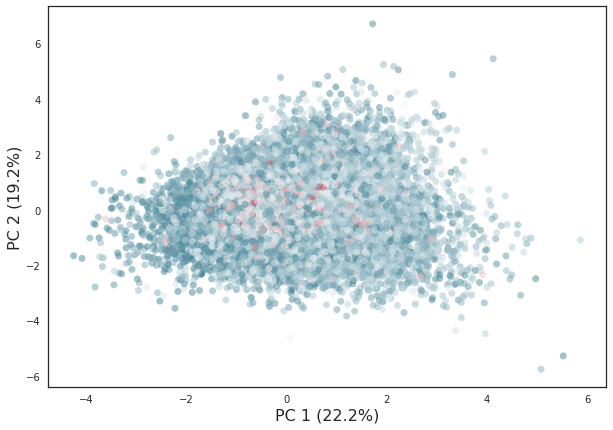

In [14]:
sns.set_style('white')

fig,ax = plt.subplots(figsize=(10,7))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, edgecolor='none', alpha=0.5,
            cmap=cmap)

ax.set_xlabel('PC 1 (22.2%)',fontsize=16)
ax.set_ylabel('PC 2 (19.2%)',fontsize=16)

In [15]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1, min_samples_leaf=2, max_depth=15)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=True, random_state=0,
           verbose=0, warm_start=False)

In [16]:
pred_conc_test = rf.predict(X_test)
pred_conc_test.shape

(13562,)

In [17]:
y_test.shape

(13562,)

/sw/anaconda-4.3.1/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


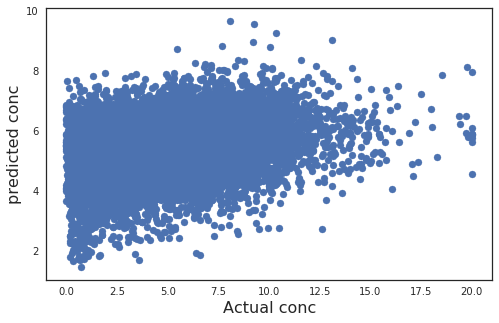

In [18]:
fg , axs = plt.subplots(figsize=(8,5))
axs.scatter(y_test, pred_conc_test)
axs.set_ylabel('predicted conc',fontsize=16)
axs.set_xlabel('Actual conc',fontsize=16)


In [19]:
from sklearn.metrics import r2_score
r2_score(y_test, pred_conc_test)

0.10056455239939377

In [20]:
rf.score(X_test,y_test)

0.10056455239939377

In [43]:
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor(hidden_layer_sizes=(15,20,15),learning_rate_init=0.0001, max_iter=400)
mlp_reg.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 20, 15), learning_rate='constant',
       learning_rate_init=0.0001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [44]:
pred_conc_nn = mlp_reg.predict(X_test)
mlp_reg.score(X_test,y_test)

0.10463829229442168

/sw/anaconda-4.3.1/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


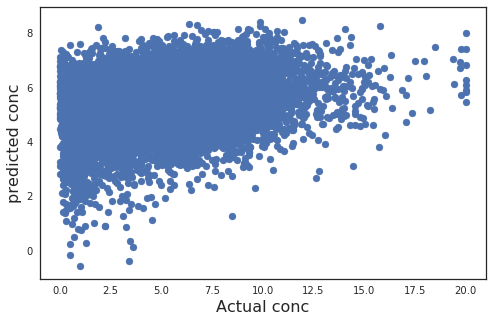

In [45]:
fig_nn, xs_nn = plt.subplots(figsize=(8,5))
xs_nn.scatter(y_test, pred_conc_nn)
xs_nn.set_ylabel('predicted conc',fontsize=16)
xs_nn.set_xlabel('Actual conc',fontsize=16)